In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

import seaborn as sns
import matplotlib.pyplot as plt
#from scipy.integrate import odeint
import numpy as np
import pandas as pd
import os
import json
#from skopt.space import Space
#from eml.net.reader import keras_reader
from codecarbon import EmissionsTracker
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

# Hardware Dimensioning for Sustainability - Data Exploration

This notebook has the purpose of provide some insights in the dataset gathered during the benchmark phase of HADA

## Anticipate and Contingency

We first present the two algorithms we tested, i.e. ANTICIPATE and CONTINGENCY, two stochastic algorithms for energy systems, that compute the total amount of energy to be produced over a daily time horizon to meat the required load, minimising the total energy cost. The algorithms were executed on two different Hardware platforms.

### Load and combine data

We first load the datasets and we combine them. We have four dataset, one for each couple of `algorithm` and a `platform`, so we add those columns to keep track of this information. Each algorithm has a single configuration parameter, which is the number of Scenarios for ANTICIPATE and the number of Traces for CONTINGENCY. To join the datasets, we unify the `nScenarios` and `nTraces` columns for ANTICIPATE and CONTINGENCY respectively into the `parameter` column.

In [2]:
def load_data(file_path, algorithm, platform):
    df = pd.read_csv(file_path)
    df['algorithm'] = algorithm
    df['platform'] = platform
    # Standardize the configuration parameter column name
    if algorithm.upper() == "ANTICIPATE":
        df.rename(columns={'nScenarios': 'parameter'}, inplace=True)
    elif algorithm.upper() == "CONTINGENCY":
        df.rename(columns={'nTraces': 'parameter'}, inplace=True)
    return df

# Load each dataset (adjust the paths as needed)
df_anticipate_leonardo = load_data('../data/benchmark/anticipate_leonardo.csv', 'ANTICIPATE', 'leonardo')
df_anticipate_mbp19 = load_data('../data/benchmark/anticipate_mbp19.csv', 'ANTICIPATE', 'mbp19')
df_contingency_leonardo = load_data('../data/benchmark/contingency_leonardo.csv', 'CONTINGENCY', 'leonardo')
df_contingency_mbp19 = load_data('../data/benchmark/contingency_mbp19.csv', 'CONTINGENCY', 'mbp19')

# Combine all dataframes into one
df = pd.concat([df_anticipate_leonardo, df_anticipate_mbp19, 
                df_contingency_leonardo, df_contingency_mbp19], ignore_index=True)

# Display the first few rows of the combined dataframe
df.head()

,parameter,pv_mean,pv_std,load_mean,load_std,sol(keuro),time(sec),memAvg(MB),memPeak(MB),CO2e(kg),CO2eRate(kg/s),cpuEnergy(kW),ramEnergy(kW),totEnergy(kW),cpuCount,algorithm,platform
0,1,265.314583,274.018628,310.939583,166.578779,364.16,14.09,106.00,108.54,0.000142,0.000036,0.000212,0.000206,0.000418,16,ANTICIPATE,leonardo
1,1,270.727083,279.613203,317.285417,169.978294,371.95,1.26,106.67,109.23,0.000059,0.000031,0.000073,0.000100,0.000172,16,ANTICIPATE,leonardo
2,1,273.386458,281.780059,322.672917,166.359854,375.85,1.24,109.79,112.43,0.000064,0.000034,0.000087,0.000099,0.000186,16,ANTICIPATE,leonardo
3,1,292.152083,301.113169,344.818750,177.771852,402.80,1.23,105.37,110.57,0.000061,0.000032,0.000081,0.000099,0.000180,16,ANTICIPATE,leonardo
4,1,267.479167,276.259631,313.482292,167.937302,367.30,1.25,108.63,111.24,0.000069,0.000035,0.000099,0.000104,0.000203,16,ANTICIPATE,leonardo


### Summary Statistics

To get a high-level summary of each metric, we run `.describe()` for statistical insights.

In [3]:
# Lets drop some of the columns
columns = ['parameter','cpuCount']
df_overview = df.drop(columns=columns)

print(df_overview.describe())
print("="*50)
print(df_overview.info())

            pv_mean        pv_std     load_mean      load_std    sol(keuro)  \
count  11900.000000  11900.000000  11900.000000  11900.000000  11900.000000   
mean     269.264837    277.453998    317.214181    166.427673    353.151242   
std       10.956221     11.331598     12.866123      7.290310     75.824490   
min      246.585417    254.152197    291.043750    150.043095    233.130000   
25%      264.814583    272.939977    311.839583    162.922268    309.870000   
50%      268.027083    276.661763    316.348958    166.359854    341.340000   
75%      273.432292    281.780059    322.672917    169.575057    367.090000   
max      295.090625    304.773592    346.844792    185.276198    813.710000   

          time(sec)    memAvg(MB)   memPeak(MB)      CO2e(kg)  CO2eRate(kg/s)  \
count  11900.000000  11900.000000  11900.000000  11900.000000    11900.000000   
mean     138.560767    147.719032    177.013474      0.000690        0.000020   
std      165.598068     32.952518     48.4095

Let's now try to print some statistics grouping by algorithm and platform

In [11]:
# Get descriptive statistics grouped by algorithm and platform
summary_stats = df_overview.groupby(['algorithm', 'platform']).describe()
print(summary_stats)

                     sol(keuro)                                         \
                          count        mean        std     min     25%   
algorithm   platform                                                     
ANTICIPATE  leonardo     2900.0  318.218303  34.382923  233.13  290.70   
            mbp19        3000.0  317.806813  34.325153  233.13  290.47   
CONTINGENCY leonardo     3000.0  387.707710  88.520354  290.43  337.04   
            mbp19        3000.0  387.707710  88.520354  290.43  337.04   

                                                time(sec)              ...  \
                          50%       75%     max     count        mean  ...   
algorithm   platform                                                   ...   
ANTICIPATE  leonardo  317.260  348.6550  413.00    2900.0   52.876531  ...   
            mbp19     316.645  347.9925  413.00    3000.0   93.023027  ...   
CONTINGENCY leonardo  361.840  402.5800  813.71    3000.0  340.215013  ...   
            m

### Exploring performance metrics

Since `sol(keuro)`, `time(sec)`, `memAvg(MB)` and `memPeak(MB)` represent performance metrics, visualize and compare them across algorithms and platforms. First, we compare solution cost and time

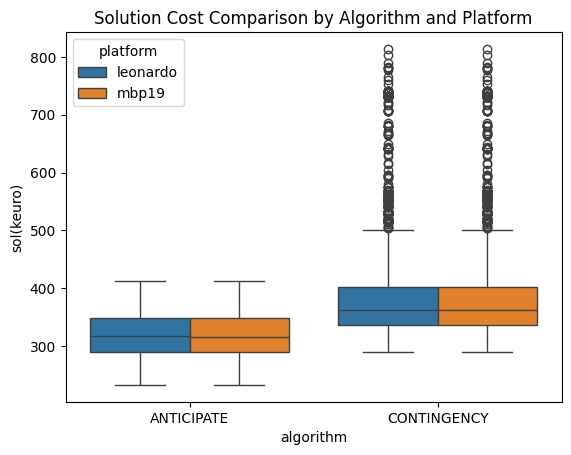

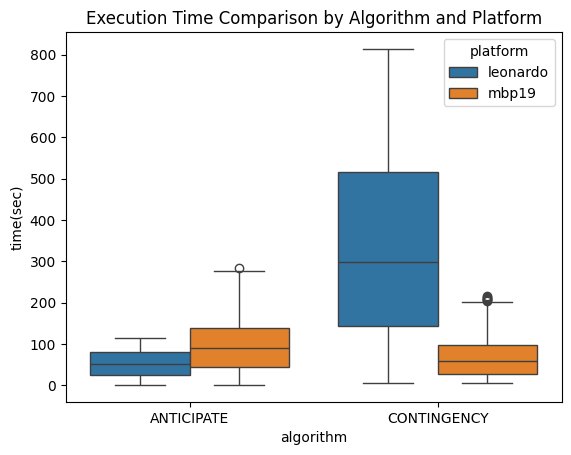

In [13]:
# Solution Cost Comparison by Algorithm and Platform
sns.boxplot(data=df, x='algorithm', y='sol(keuro)', hue='platform')
plt.title('Solution Cost Comparison by Algorithm and Platform')
plt.show()

# Time Required Comparison
sns.boxplot(data=df, x='algorithm', y='time(sec)', hue='platform')
plt.title('Execution Time Comparison by Algorithm and Platform')
plt.show()

As we can notice, the solution cost is genenrally higher for CONTINGENCY, which also shows a considerable amount of outliers. Then we may also point out that the solution cost is pretty uniform across both Hardware platform.

This is not true for the execution time instead, which is generally lower on `leonardo` for ANTICIPATE, and on `mpb19` for CONTINGENCY. The execution time for CONTINGENCY on `leonardo` overall is considerably higher, and has a wider distribution. Probably on `leonardo` the algorithm reacts differenty to the increase in the number of Traces.

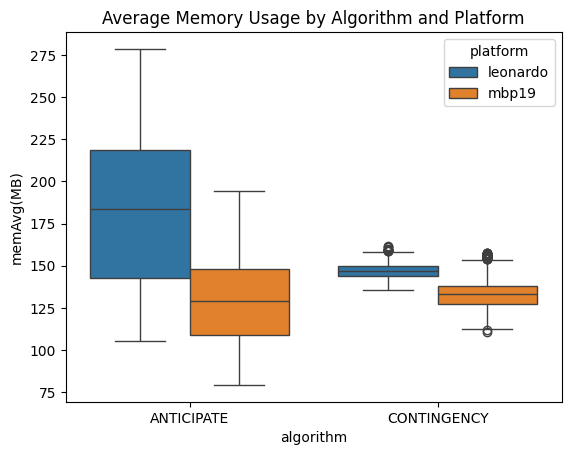

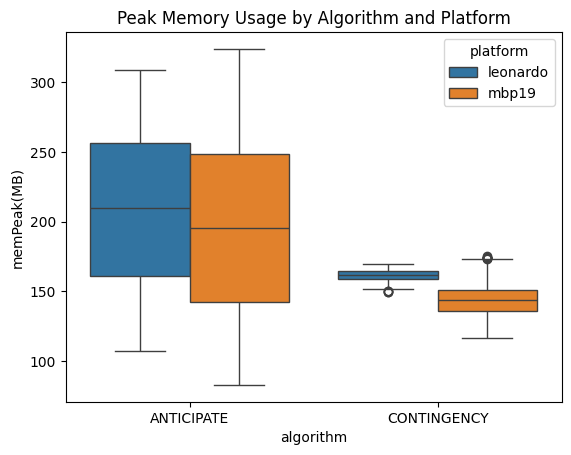

In [14]:
# Average Memory Usage
sns.boxplot(data=df, x='algorithm', y='memAvg(MB)', hue='platform')
plt.title('Average Memory Usage by Algorithm and Platform')
plt.show()

# Peak Memory Usage
sns.boxplot(data=df, x='algorithm', y='memPeak(MB)', hue='platform')
plt.title('Peak Memory Usage by Algorithm and Platform')
plt.show()

Here we can notice that the memory consumption of ANTICIPATE tends to be a little bit higher with respect to CONTINGENCY, and it shows more variablity.

### Energy and Emission Analysis

Explore the CO2 emissions `CO2e(kg)` and energy consumption metrics to compare environmental impact across algorithms and platforms

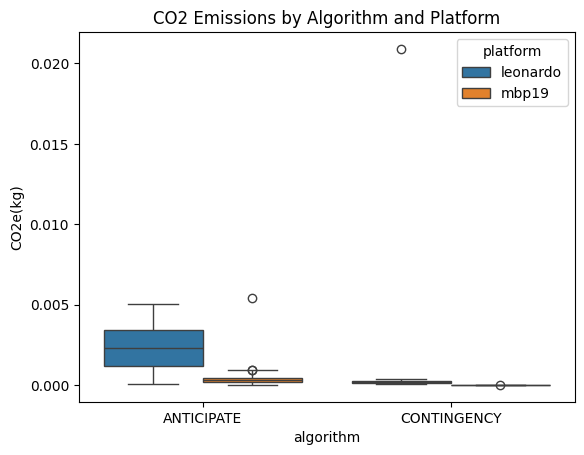

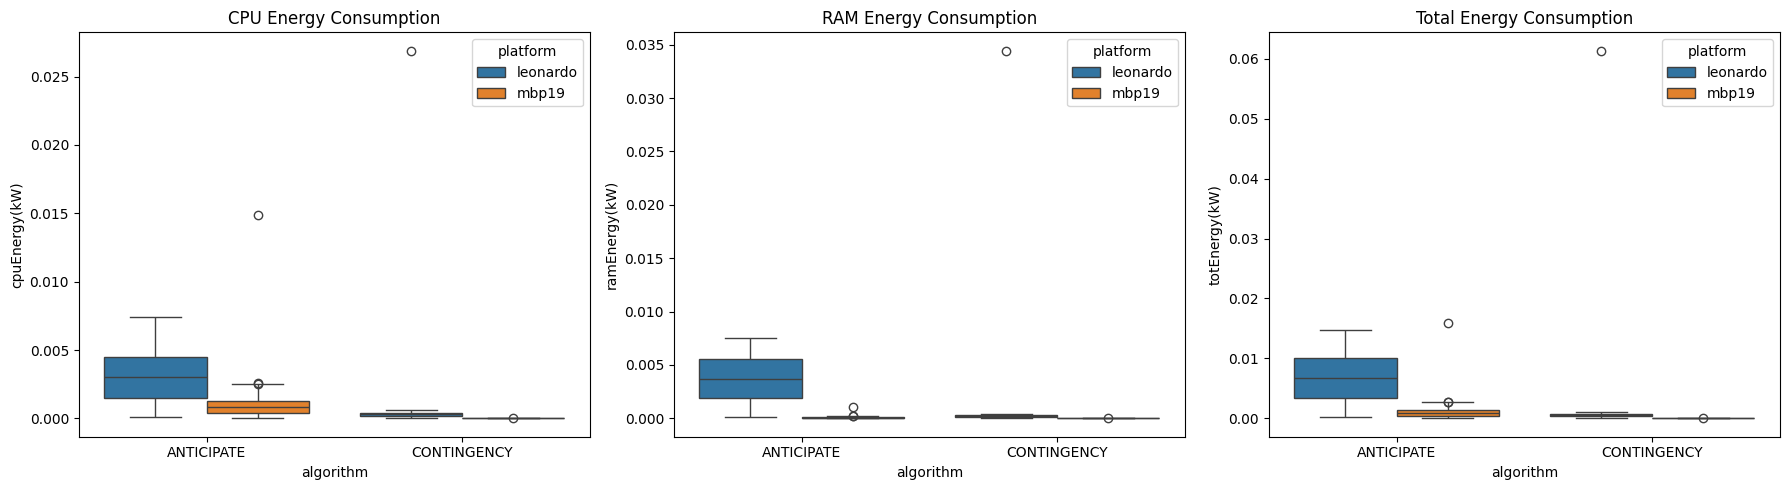

In [15]:
# CO2 Emissions by Algorithm and Platform
sns.boxplot(data=df, x='algorithm', y='CO2e(kg)', hue='platform')
plt.title('CO2 Emissions by Algorithm and Platform')
plt.show()

# Energy Consumption: CPU, RAM, and Total
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(data=df, x='algorithm', y='cpuEnergy(kW)', hue='platform', ax=axes[0])
axes[0].set_title('CPU Energy Consumption')

sns.boxplot(data=df, x='algorithm', y='ramEnergy(kW)', hue='platform', ax=axes[1])
axes[1].set_title('RAM Energy Consumption')

sns.boxplot(data=df, x='algorithm', y='totEnergy(kW)', hue='platform', ax=axes[2])
axes[2].set_title('Total Energy Consumption')

plt.tight_layout()
plt.show()

Emissions tend to be pretty low and concentrated into a very narrow interval. As we can notice by the boxplots, we have a single instance on both ANTICIPATE and CONTINGENCY for which the energy consumption, and consequently the Carbon Emissions are way higher. Could be interesting to find this instance. 

Then we can also point out that the box-plots for the emissions and the energy consumption are very similar. This reflects the fact that the Carbon Emissions are directly proportional to the energy consumption. The only other factor which influences them is the Carbon Intensity of the Country on which the algorithm is executed, which here is fixed, so actually the Carbon Emissions depends only on the Energy Usage.

### Performance vs. Emissions Correlation

Analyze if there's a correlation between performance and environmental metrics

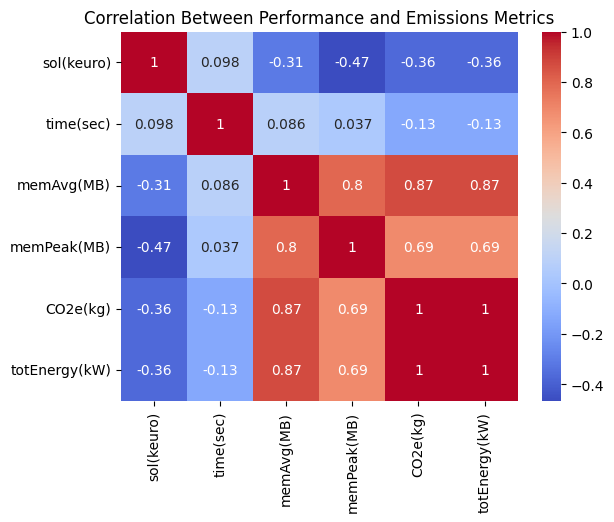

In [16]:
# Correlation matrix for numeric columns
correlation_matrix = df[['sol(keuro)', 'time(sec)', 'memAvg(MB)', 'memPeak(MB)', 'CO2e(kg)', 'totEnergy(kW)']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between Performance and Emissions Metrics')
plt.show()

This confirms what we've said before: the total energy and the CO2e emissions have a correlation of 1

### Comparison of Core Counts

Check if CPU core count impacts solution time or energy consumption.

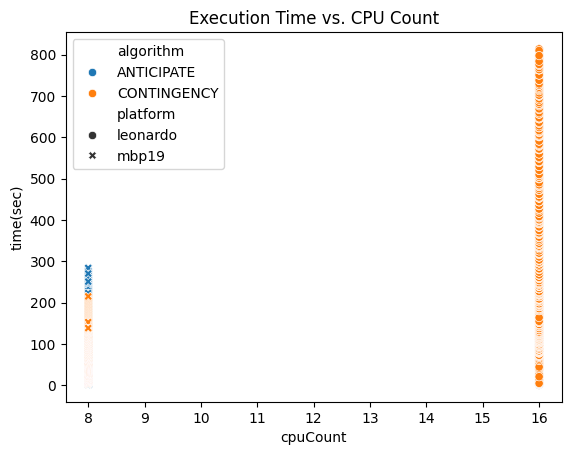

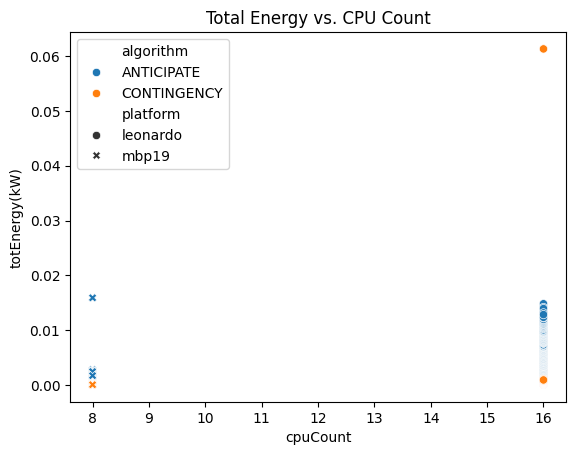

In [17]:
# Execution Time vs. CPU Count
sns.scatterplot(data=df, x='cpuCount', y='time(sec)', hue='algorithm', style='platform')
plt.title('Execution Time vs. CPU Count')
plt.show()

# Total Energy vs. CPU Count
sns.scatterplot(data=df, x='cpuCount', y='totEnergy(kW)', hue='algorithm', style='platform')
plt.title('Total Energy vs. CPU Count')
plt.show()

### Distribution of Key Metrics

Let's create a pairplot to visualize the distributions of some key metrics. Since the Dataset is pretty big, and the points end up to be a little too cluttered, let's took a random sample from the dataset and try to generate the Pairplot:

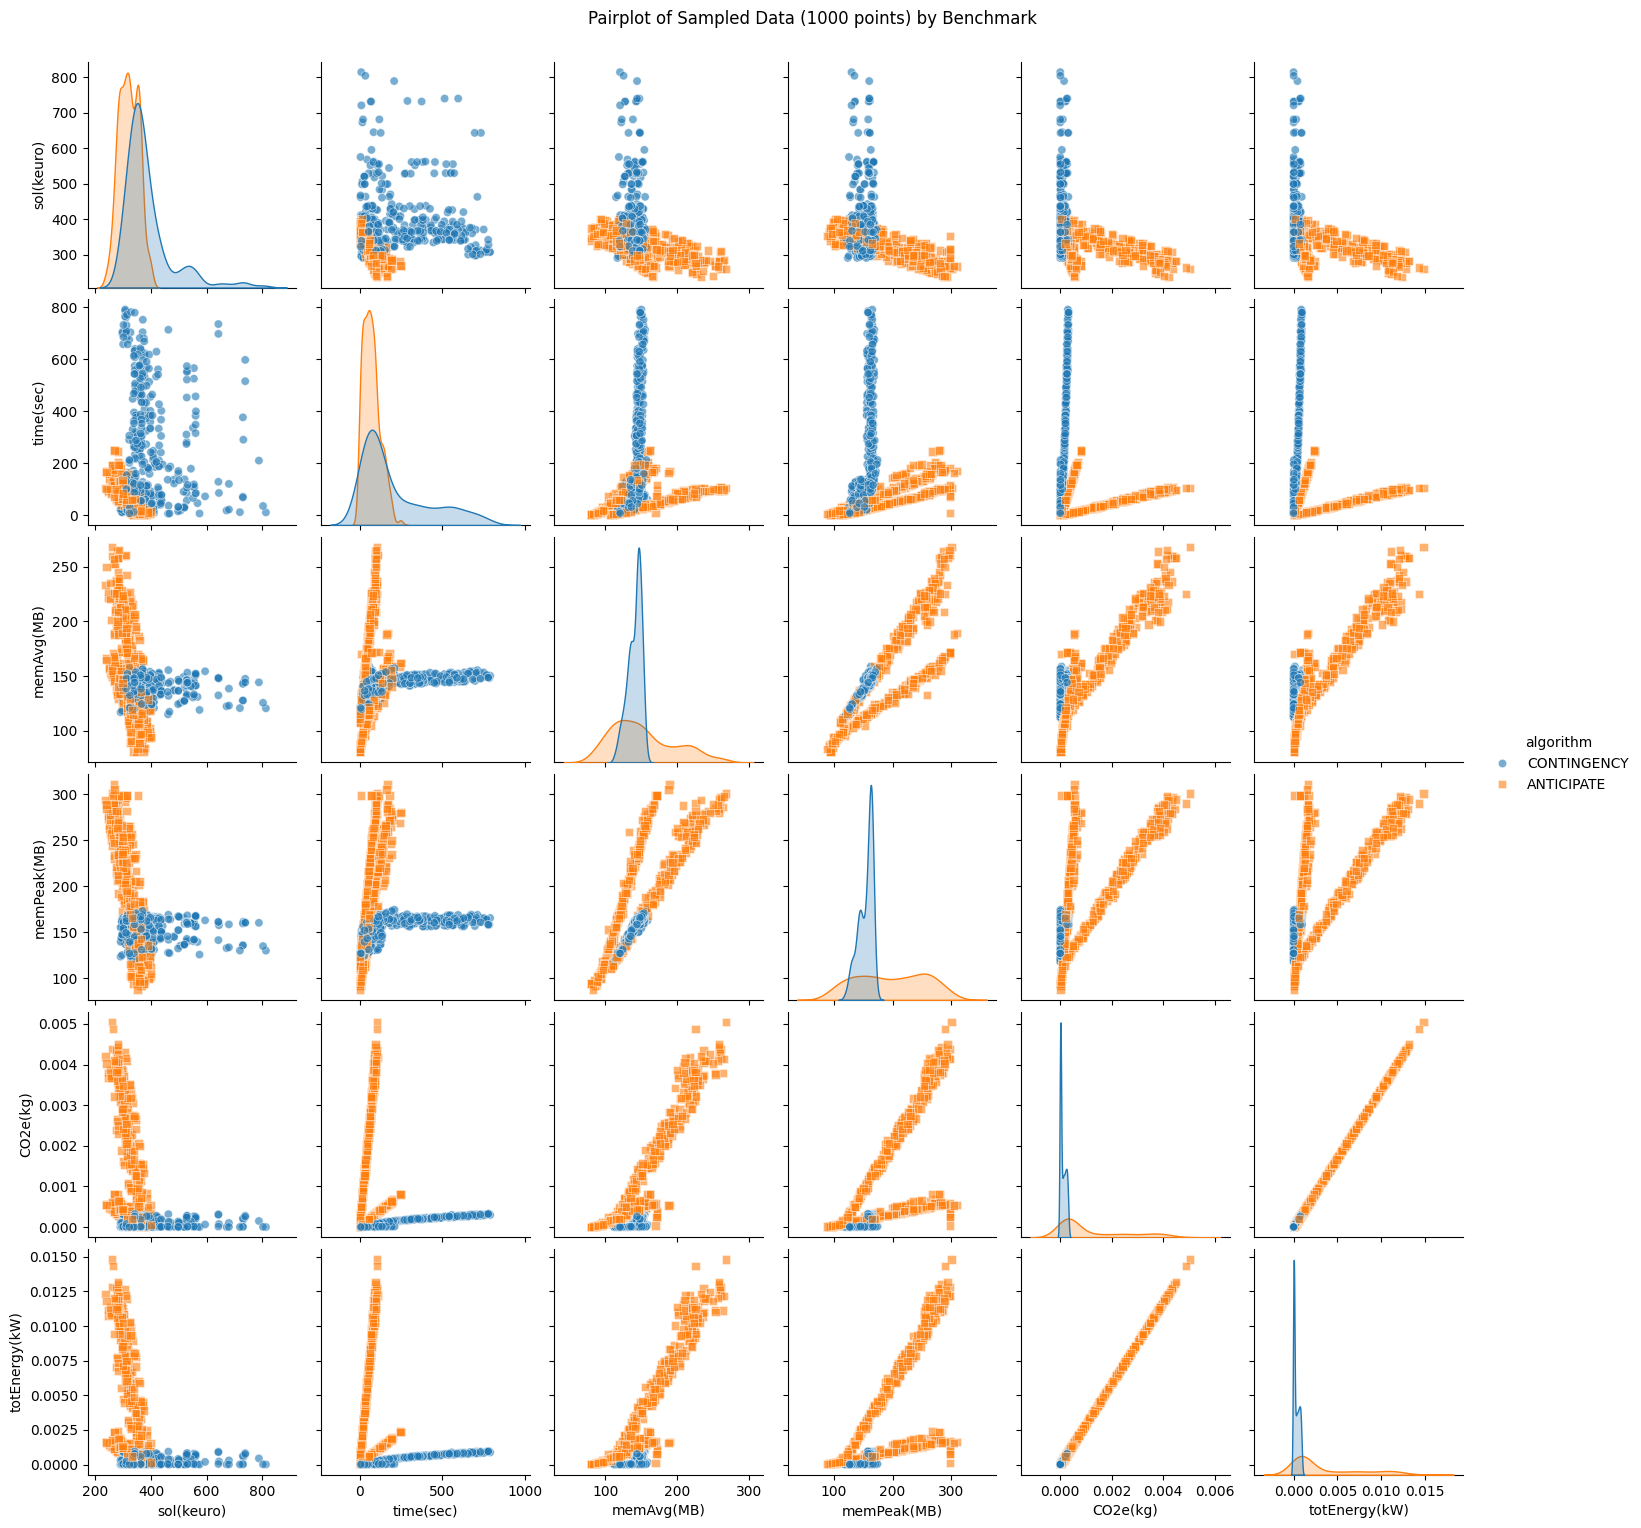

In [23]:
# Randomly sample 1000 points from the full dataset
df_sample = df.sample(n=1000, random_state=42)

# Create a pairplot on the sampled data
selected_columns = ['sol(keuro)', 'time(sec)', 'memAvg(MB)', 'memPeak(MB)', 'CO2e(kg)', 'totEnergy(kW)']
sns.pairplot(
    df_sample[selected_columns + ['algorithm']], 
    hue='algorithm', 
    diag_kind='kde', 
    markers=["o", "s"],
    plot_kws={'alpha': 0.6}  # Adjust transparency for scatter points
)
plt.suptitle("Pairplot of Sampled Data (1000 points) by Benchmark", y=1.02)
plt.show()

## Min-Cut/Max-Flow Algorithms

Let's now perform some analysis on the Min-Cut/Max-Flow algorithms

In [4]:
def load_min_cut_data(file_path, benchmark, platform):
    df = pd.read_csv(file_path)
    # Rename 'algorithm' column to 'implementation' to avoid conflict with the benchmark info
    df.rename(columns={'algorithm': 'implementation'}, inplace=True)
    df['benchmark'] = benchmark
    df['platform'] = platform
    return df

# Load each dataset (adjust file paths as needed)
df_bk_leonardo   = load_min_cut_data('../data/benchmark/bk_leonardo.csv',    'BK',    'leonardo')
df_bk_pc         = load_min_cut_data('../data/benchmark/bk_pc.csv',          'BK',    'pc')
df_eibfs_leonardo = load_min_cut_data('../data/benchmark/eibfs_leonardo.csv','EIBFS', 'leonardo')
df_eibfs_pc      = load_min_cut_data('../data/benchmark/eibfs_pc.csv',       'EIBFS', 'pc')
df_hpf_leonardo  = load_min_cut_data('../data/benchmark/hpf_leonardo.csv',   'HPF',   'leonardo')
df_hpf_mbp19     = load_min_cut_data('../data/benchmark/hpf_mbp19.csv',      'HPF',   'mbp19')
df_hpf_pc        = load_min_cut_data('../data/benchmark/hpf_PC.csv',         'HPF',   'pc')

# Combine all datasets into one DataFrame
df_min_cut = pd.concat([
    df_bk_leonardo, df_bk_pc, 
    df_eibfs_leonardo, df_eibfs_pc, 
    df_hpf_leonardo, df_hpf_mbp19, df_hpf_pc
], ignore_index=True)

# Inspect the first few rows
df_min_cut.head()

,implementation,nodes,arcs,time(s),memPeak(MB),memAvg(MB),CO2eq(kg),CO2eRate(kg/s),cpuEnergy(kW),ramEnergy(kW),totEnergy(kW),cpuCount,benchmark,platform,CO2eRate (kg/s)
0,BK,1118,2222,0.000150,89.2266,89.2266,0.000003,0.00003,0.000004,0.000006,0.000010,8,BK,leonardo,NaN
1,MBK,1118,2222,0.000121,89.3477,89.3477,0.000003,0.00003,0.000004,0.000006,0.000010,8,BK,leonardo,NaN
2,MBK2,1118,2222,0.000182,89.1992,89.1992,0.000003,0.00003,0.000004,0.000006,0.000009,8,BK,leonardo,NaN
3,BK,1118,2228,0.000151,89.3164,89.3164,0.000003,0.00003,0.000004,0.000006,0.000009,8,BK,leonardo,NaN
4,MBK,1118,2228,0.000126,89.1797,89.1797,0.000003,0.00003,0.000004,0.000006,0.000009,8,BK,leonardo,NaN


Let's print some descriptive statistics

In [5]:
# Lets drop some of the columns
columns = ['implementation','cpuCount']
df_min_cut_overview = df_min_cut.drop(columns=columns)

print(df_min_cut_overview.describe())
print("="*50)
print(df_min_cut_overview.info())

              nodes          arcs       time(s)    memPeak(MB)    memAvg(MB)  \
count  4.976000e+04  4.976000e+04  49760.000000   49760.000000  49760.000000   
mean   1.354333e+05  1.396830e+06      0.232135     159.419272    143.171791   
std    3.783833e+06  2.734812e+07      3.176720    1147.370794    867.280696   
min    4.000000e+01  7.600000e+01      0.000002       0.000000      0.000000   
25%    8.000000e+01  2.460000e+02      0.000025      84.710900     84.710900   
50%    2.220000e+02  4.960000e+02      0.000133      89.250000     89.250000   
75%    1.118000e+03  2.236000e+03      0.000205      89.347700     89.343800   
max    6.885000e+08  4.673839e+09    213.772000  120055.000000  81866.100000   

          CO2eq(kg)  CO2eRate(kg/s)  cpuEnergy(kW)  ramEnergy(kW)  \
count  4.976000e+04    46261.000000   4.976000e+04   4.976000e+04   
mean   8.219425e-06        0.000022   1.807412e-05   1.962716e-05   
std    1.277790e-04        0.000014   2.287604e-04   2.489278e-04   
min

In [27]:
summary_stats = df_min_cut.groupby(['benchmark', 'platform']).describe()
print(summary_stats)

                      nodes                                               \
                      count          mean           std     min      25%   
benchmark platform                                                         
BK        leonardo  14414.0  1.529236e+05  6.145016e+06    40.0     86.0   
          pc         8867.0  1.394007e+04  8.355467e+04    40.0     68.0   
EIBFS     leonardo  14115.0  1.073615e+05  2.233287e+06    40.0     80.0   
          pc         8865.0  1.390601e+04  8.353330e+04    40.0     68.0   
HPF       leonardo   1300.0  1.692281e+06  8.425491e+06  2002.0  25922.0   
          mbp19      1092.0  1.921566e+05  3.479400e+05  2002.0  21058.0   
          pc         1107.0  3.277558e+05  1.285954e+06  2002.0  21122.0   

                                                        arcs                \
                         50%       75%          max    count          mean   
benchmark platform                                                           
BK   

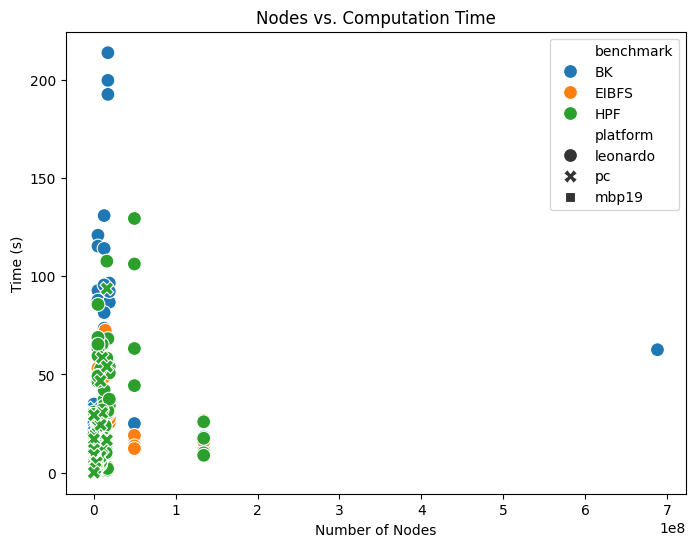

In [28]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_min_cut, 
                x='nodes', 
                y='time(s)', 
                hue='benchmark', 
                style='platform', 
                s=100)
plt.title("Nodes vs. Computation Time")
plt.xlabel("Number of Nodes")
plt.ylabel("Time (s)")
plt.show()

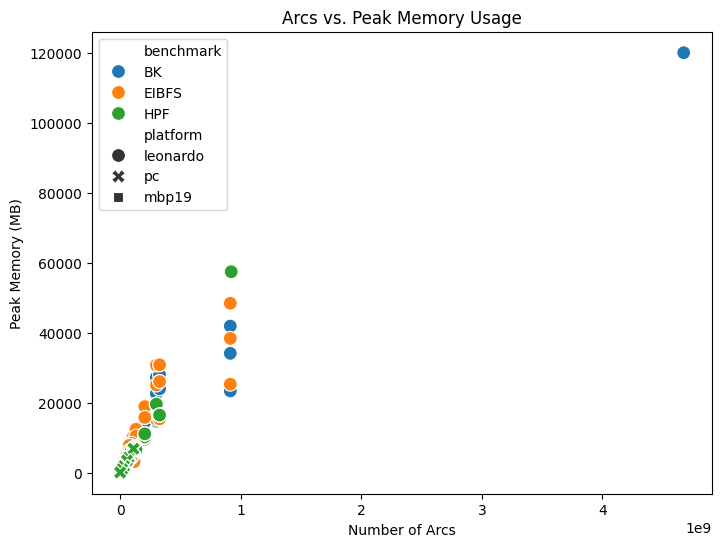

In [29]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_min_cut, 
                x='arcs', 
                y='memPeak(MB)', 
                hue='benchmark', 
                style='platform', 
                s=100)
plt.title("Arcs vs. Peak Memory Usage")
plt.xlabel("Number of Arcs")
plt.ylabel("Peak Memory (MB)")
plt.show()

### Distribution Key Metrics

Let's now take a look at some variables distributions.

In [ ]:
# Select a subset of numeric columns for the pairplot
selected_columns = ['nodes', 'arcs', 'time(s)', 'memPeak(MB)', 'totEnergy(kW)']

sns.pairplot(df_min_cut[selected_columns + ['benchmark']], 
             hue='benchmark', 
             diag_kind='hist', 
             markers=["o", "s", "D"])
plt.suptitle("Pairplot of Min-Cut/Max-Flow Metrics by Benchmark", y=1.02)
plt.show()

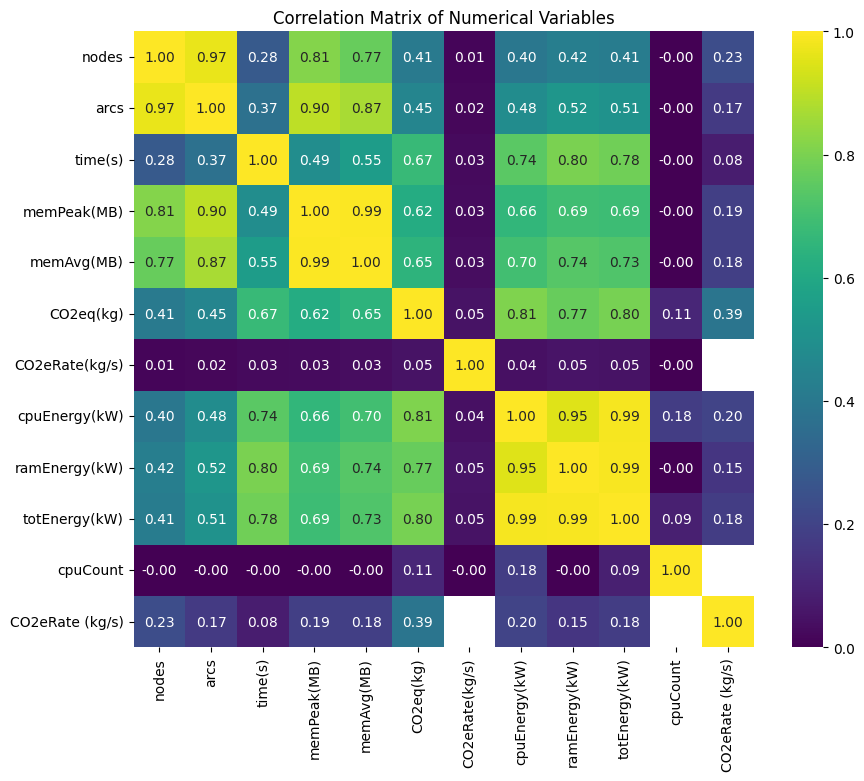

In [31]:
numeric_cols = df_min_cut.select_dtypes(include=[np.number])
corr_matrix = numeric_cols.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

* We could remove CO2eRate, since it is an attribute that basically varies depending on the current Carbon Intensity, so it is basically fixed throughout the benchmar runs. THe low correlation with all the other variables suggests exactly that

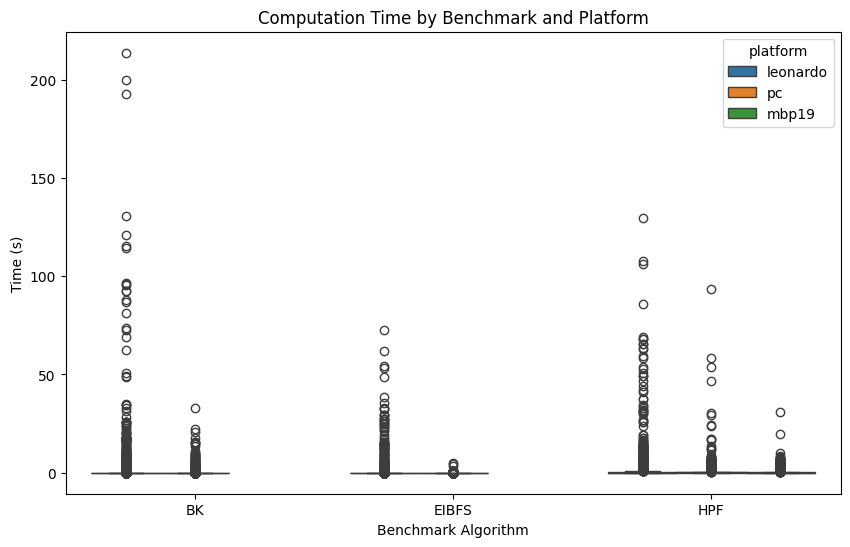

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_min_cut, x='benchmark', y='time(s)', hue='platform')
plt.title("Computation Time by Benchmark and Platform")
plt.xlabel("Benchmark Algorithm")
plt.ylabel("Time (s)")
plt.show()

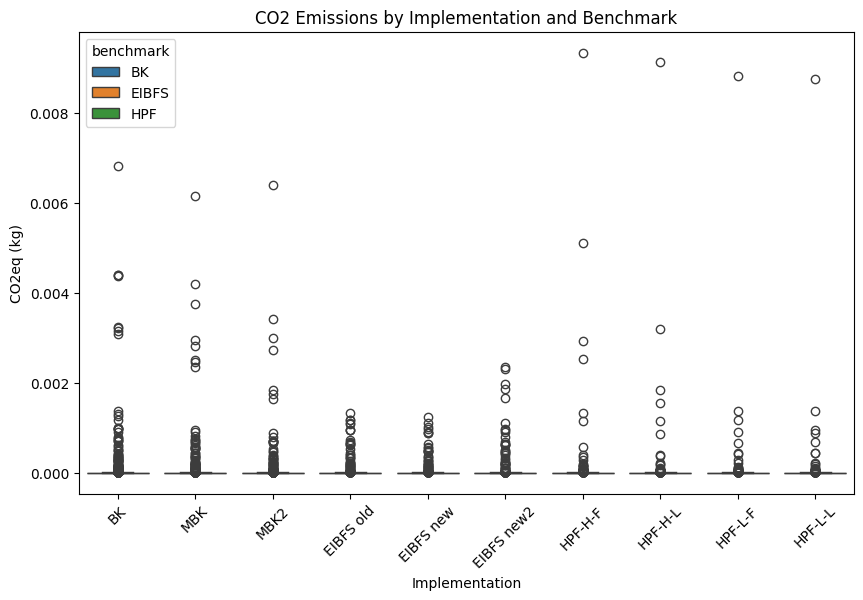

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_min_cut, x='implementation', y='CO2eq(kg)', hue='benchmark')
plt.title("CO2 Emissions by Implementation and Benchmark")
plt.xlabel("Implementation")
plt.ylabel("CO2eq (kg)")
plt.xticks(rotation=45)
plt.show()